In [302]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import joblib
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os
from datetime import datetime
from sklearn.metrics import ConfusionMatrixDisplay

In [303]:
data = pd.read_csv('cumulative.csv')
data.head(5)

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [304]:

def preprocess_inputs(df):
    df = df.copy()
    
    # Drop unused columns
    df = df.drop(['rowid', 'kepid', 'kepoi_name', 'kepler_name', 
                  'koi_pdisposition', 'koi_score', 'koi_tce_delivname',
                 'koi_fpflag_nt','koi_fpflag_ss','koi_fpflag_co','koi_fpflag_ec',
                 'koi_tce_plnt_num'], axis=1) # the last 4 columns are removed because after scaling they are almost 0
    
    # Limit target values to CANDIDATE and CONFIRMED
    false_positive_rows = df.query("koi_disposition == 'FALSE POSITIVE'").index
    df = df.drop(false_positive_rows, axis=0).reset_index(drop=True)
    
    # Drop columns with all missing values
    df = df.drop(['koi_teq_err1', 'koi_teq_err2'], axis=1)
    
    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'koi_disposition' in numeric_cols:
        numeric_cols.remove('koi_disposition')
    
    # Handle outliers using IQR
    for col in numeric_cols:
        if df[col].notna().sum() > 0:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR  # Using 3*IQR for less aggressive outlier removal
            upper_bound = Q3 + 3 * IQR
            df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    
    # Fill missing values with median as its more robust than mean
    for column in df.columns[df.isna().sum() > 0]:
        df[column] = df[column].fillna(df[column].median())
    
    # Feature engineering - create interaction features
    # Transit depth to stellar radius ratio
    if 'koi_depth' in df.columns and 'koi_srad' in df.columns:
        df['depth_to_srad'] = df['koi_depth'] / (df['koi_srad'] + 1e-10)
    
    # Planet-star radius ratio
    if 'koi_prad' in df.columns and 'koi_srad' in df.columns:
        df['prad_to_srad_ratio'] = df['koi_prad'] / (df['koi_srad'] + 1e-10)
    
    # Orbital period to impact parameter ratio
    if 'koi_period' in df.columns and 'koi_impact' in df.columns:
        df['period_to_impact'] = df['koi_period'] / (df['koi_impact'] + 1e-10)
    
    # Insolation flux feature
    if 'koi_insol' in df.columns:
        df['log_insol'] = np.log1p(df['koi_insol'])
    
    # Signal-to-noise ratio features
    if 'koi_model_snr' in df.columns:
        df['log_snr'] = np.log1p(df['koi_model_snr'])
    
    # Remove highly correlated features (> 0.95 correlation) to eliminate multicollinearity
    numeric_df = df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
    df = df.drop(to_drop, axis=1)
    
    # Split df into X and y
    y = df['koi_disposition']
    X = df.drop('koi_disposition', axis=1)
    
    # Train-test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.7, shuffle=True, random_state=1, stratify=y
    )
    
    # Normalizing features
    scaler = RobustScaler()
    scaler.fit(X_train)
    joblib.dump(scaler, 'scaler.pkl')
    X_train = pd.DataFrame(scaler.transform(X_train), 
                          index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), 
                         index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test


In [305]:

X_train, X_test, y_train, y_test = preprocess_inputs(data)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Class distribution in training: {y_train.value_counts().to_dict()}")


Training set shape: (3178, 34)
Test set shape: (1363, 34)
Class distribution in training: {'CONFIRMED': 1605, 'CANDIDATE': 1573}


In [313]:
X_train.head(5)

,koi_period,koi_period_err1,koi_time0bk,koi_time0bk_err1,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_depth,...,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,depth_to_srad,prad_to_srad_ratio,period_to_impact,log_insol,log_snr
2675,-0.374906,-0.243944,-0.206350,-0.399702,0.866789,-0.650327,-0.883397,-0.745351,-0.421844,-0.490523,...,1.116505,-3.696721,-1.015581,-0.336887,-0.693829,-0.449751,-0.632869,-0.236451,0.945364,0.008060
4341,1.762624,1.586664,0.229832,0.132737,-0.076622,0.581699,0.073168,-0.808829,0.791583,-0.175835,...,0.791262,-0.663934,-0.153350,0.228496,-0.462356,-0.169997,-0.245152,0.924820,-0.626088,-0.898936
1088,-0.165276,-0.159992,-0.102792,-0.253542,0.600208,-0.267974,-0.584853,0.264315,-0.295090,0.297373,...,-0.703883,0.360656,-1.258725,-0.346777,0.124004,0.755774,0.305840,-0.184536,-0.338193,0.556849
3384,-0.262726,-0.198460,-0.108678,-0.231171,-0.603400,0.735294,0.682736,-0.222330,-0.282565,-0.147090,...,-0.121359,-0.721311,0.338284,-1.036611,-0.058459,-0.160027,-0.252176,1.251285,0.592265,0.120851
767,0.293574,0.054317,0.002811,-0.211782,0.638519,-0.336601,-0.636241,0.563376,-0.207916,0.547174,...,0.771845,-0.163934,0.631571,1.250407,0.122232,0.350518,0.510005,-0.078181,-0.062136,0.571759


In [307]:

# Models defination
models = {
    "Logistic Regression": LogisticRegression(),
    "      Decision Tree": DecisionTreeClassifier(),
    "      Random Forest": RandomForestClassifier(),
    "  Gradient Boosting": GradientBoostingClassifier(),
    "           LightGBM": LGBMClassifier(),
    "           CatBoost": CatBoostClassifier(verbose=0),
    "     SGD Classifier": SGDClassifier(loss="log_loss"),
    " Naive Bayes (Gauss)": GaussianNB(),
    " Naive Bayes (Bern)": BernoulliNB(),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "                 LDA": LinearDiscriminantAnalysis(),
    "                 QDA": QuadraticDiscriminantAnalysis(),
    " Neural Net (MLP)": MLPClassifier(max_iter=500)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained.")
    filename = name.strip().replace(" ", "_").lower() + ".pkl"
    joblib.dump(model, filename)
    print(f"Saved {name} to {filename}")

Logistic Regression trained.
Saved Logistic Regression to logistic_regression.pkl
      Decision Tree trained.
Saved       Decision Tree to decision_tree.pkl
      Random Forest trained.
Saved       Random Forest to random_forest.pkl
  Gradient Boosting trained.
Saved   Gradient Boosting to gradient_boosting.pkl
[LightGBM] [Info] Number of positive: 1605, number of negative: 1573
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8113
[LightGBM] [Info] Number of data points in the train set: 3178, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505035 -> initscore=0.020139
[LightGBM] [Info] Start training from score 0.020139
           LightGBM trained.
Saved            LightGBM to lightgbm.pkl
           CatBoost trained.
Saved            CatBoost to catboost.pkl
     SGD Classifier trained.
Saved      SGD Classifier 

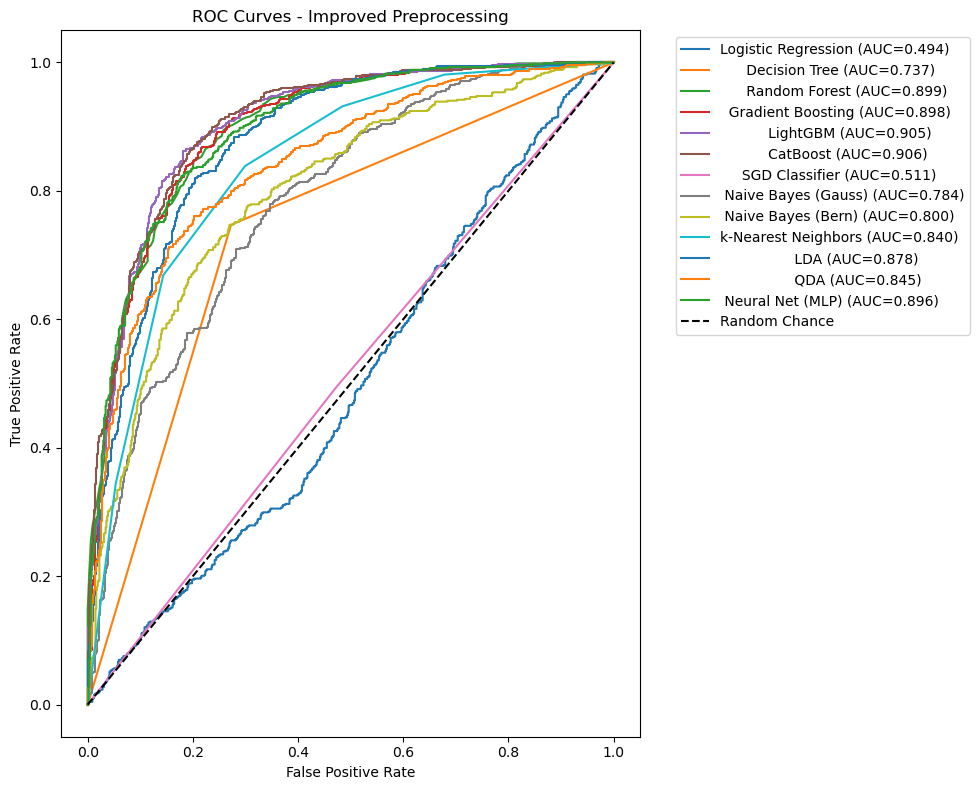


MODEL PERFORMANCE COMPARISON
               Model  Accuracy  Precision   Recall  F1 Score  ROC-AUC
            CatBoost  0.833456   0.818811 0.860465  0.839121 0.906404
            LightGBM  0.836390   0.819807 0.866279  0.842403 0.905017
       Random Forest  0.818048   0.814286 0.828488  0.821326 0.898789
   Gradient Boosting  0.823184   0.809986 0.848837  0.828957 0.897937
    Neural Net (MLP)  0.812179   0.800000 0.837209  0.818182 0.896494
                 LDA  0.804842   0.793872 0.828488  0.810811 0.878030
                 QDA  0.718269   0.666302 0.885174  0.760300 0.844830
 k-Nearest Neighbors  0.770360   0.740693 0.838663  0.786639 0.840171
  Naive Bayes (Bern)  0.738811   0.738506 0.747093  0.742775 0.799632
 Naive Bayes (Gauss)  0.495965   0.666667 0.002907  0.005789 0.783730
       Decision Tree  0.737344   0.736390 0.747093  0.741703 0.737250
      SGD Classifier  0.510638   0.515933 0.494186  0.504826 0.510797
 Logistic Regression  0.489362   0.494318 0.505814  0.500000

In [316]:

# Evaluation
results = []
plt.figure(figsize=(10, 8))

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Use sklearn's built-in metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='CONFIRMED', zero_division=0)
    recall = recall_score(y_test, y_pred, pos_label='CONFIRMED', zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label='CONFIRMED', zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC-AUC": roc_auc
    })
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label='CONFIRMED')
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Improved Preprocessing")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

df_results = pd.DataFrame(results).sort_values('ROC-AUC', ascending=False)
print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(df_results.to_string(index=False))
print("="*80)

# Save results to CSV
models_dir = os.getcwd()
results_path = os.path.join(models_dir, "model_results.csv")
df_results.to_csv(results_path, index=False)



In [309]:
from sklearn.model_selection import cross_val_score

best_clf = models[best_model["Model"]]
cv_scores = cross_val_score(best_clf, X_train, y_train, cv=5, scoring="roc_auc")

print("Cross-Validation ROC-AUC scores:", cv_scores)
print("Mean ROC-AUC:", cv_scores.mean())
print("Std deviation:", cv_scores.std())


Cross-Validation ROC-AUC scores: [0.89776987 0.90308065 0.89549523 0.90168066 0.89359486]
Mean ROC-AUC: 0.898324251475034
Std deviation: 0.0035935128269509306



Learning Curve -            CatBoost
Train size:   254 | Train ROC-AUC: 1.0000 ± 0.0000 | Val ROC-AUC: 0.8613 ± 0.0106
Train size:   508 | Train ROC-AUC: 0.9996 ± 0.0000 | Val ROC-AUC: 0.8718 ± 0.0090
Train size:   762 | Train ROC-AUC: 0.9988 ± 0.0003 | Val ROC-AUC: 0.8827 ± 0.0087
Train size:  1016 | Train ROC-AUC: 0.9984 ± 0.0003 | Val ROC-AUC: 0.8906 ± 0.0051
Train size:  1271 | Train ROC-AUC: 0.9972 ± 0.0008 | Val ROC-AUC: 0.8963 ± 0.0058
Train size:  1525 | Train ROC-AUC: 0.9967 ± 0.0008 | Val ROC-AUC: 0.8965 ± 0.0047
Train size:  1779 | Train ROC-AUC: 0.9963 ± 0.0010 | Val ROC-AUC: 0.8992 ± 0.0036
Train size:  2033 | Train ROC-AUC: 0.9960 ± 0.0007 | Val ROC-AUC: 0.8992 ± 0.0044
Train size:  2287 | Train ROC-AUC: 0.9948 ± 0.0004 | Val ROC-AUC: 0.8996 ± 0.0053
Train size:  2542 | Train ROC-AUC: 0.9933 ± 0.0008 | Val ROC-AUC: 0.8982 ± 0.0037


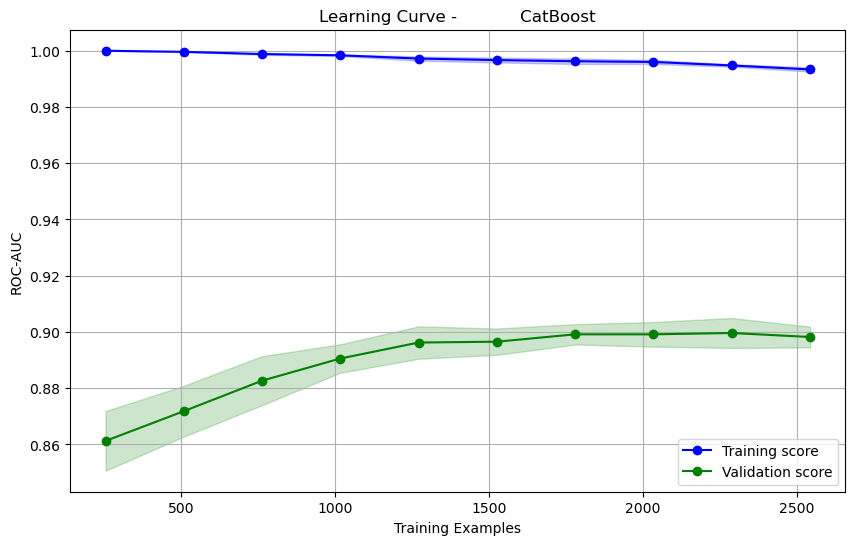

In [310]:
from sklearn.model_selection import learning_curve

# === Learning Curve for Best Model ===
train_sizes, train_scores, val_scores = learning_curve(
    best_clf,
    X_train,
    y_train,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)  # 10 points from 10% to 100% of data
)

# Compute means and stds
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Print values for inspection / sharing
print("\n" + "="*80)
print(f"Learning Curve - {best_model_name}")
print("="*80)
for size, tr_m, tr_s, va_m, va_s in zip(train_sizes, train_mean, train_std, val_mean, val_std):
    print(f"Train size: {size:5d} | "
          f"Train ROC-AUC: {tr_m:.4f} ± {tr_s:.4f} | "
          f"Val ROC-AUC: {va_m:.4f} ± {va_s:.4f}")
print("="*80)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")

plt.plot(train_sizes, val_mean, 'o-', label="Validation score", color="green")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="green")

plt.xlabel("Training Examples")
plt.ylabel("ROC-AUC")
plt.title(f"Learning Curve - {best_model_name}")
plt.legend(loc="best")
plt.grid(True)
plt.show()

